<a href="https://colab.research.google.com/github/Valli-Viswa-Varshini/Smart-Credit-Risk-Intelligence-System/blob/main/SCRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (5789, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...    

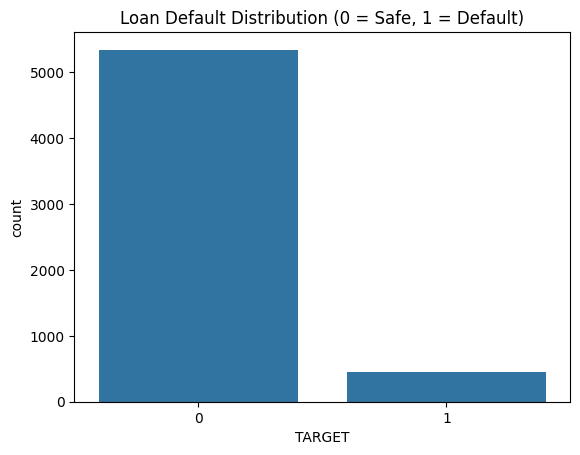

TARGET
0    0.922612
1    0.077388
Name: proportion, dtype: float64


In [1]:
# SCRIS - Step 1: Load and explore data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the main dataset
df = pd.read_csv("/content/application_train.csv")

# Preview the data
print("Dataset shape:", df.shape)
print(df.head())

# Check missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing_values[missing_values > 0])

# Check target distribution
sns.countplot(data=df, x='TARGET')
plt.title("Loan Default Distribution (0 = Safe, 1 = Default)")
plt.show()

# Basic stats
print(df['TARGET'].value_counts(normalize=True))


In [2]:
from sklearn.preprocessing import LabelEncoder

# 1. Remove columns with more than 40% missing values
threshold = 0.4
missing_ratio = df.isnull().mean()
df = df.drop(columns=missing_ratio[missing_ratio > threshold].index)

In [3]:
# 2. Fill remaining missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-3-4bce2f80766e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-3-4bce2f80766e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [4]:
# 3. Label encode binary categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])

# 4. One-hot encode remaining categorical variables
df = pd.get_dummies(df)

# 5. Drop ID column
if 'SK_ID_CURR' in df.columns:
    df.drop('SK_ID_CURR', axis=1, inplace=True)

# Check final shape
print("Final shape after preprocessing:", df.shape)


Final shape after preprocessing: (5789, 175)


In [5]:
!pip install xgboost


In [6]:
# ✅ STEP 3: Train XGBoost Model with Class Imbalance Handling

# 1. Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

# 2. Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# 3. Train-test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# 4. Handle class imbalance using scale_pos_weight
# Calculate the ratio of majority to minority class
ratio = sum(y_train == 0) / sum(y_train == 1)
print(f"Scale pos weight (class 0 : class 1) = {ratio:.2f}")

# 5. Define and train the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=ratio  # 👈 Balance importance of class 1 (defaulters)
)

model.fit(X_train, y_train)

Scale pos weight (class 0 : class 1) = 11.94


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [8]:
# 6. Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 7. Evaluate performance
print("🔍 Classification Report:\n", classification_report(y_test, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_prob))


🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1068
           1       0.18      0.31      0.23        90

    accuracy                           0.84      1158
   macro avg       0.56      0.60      0.57      1158
weighted avg       0.88      0.84      0.85      1158

🎯 ROC AUC Score: 0.6999271743653768


In [9]:
!pip install shap


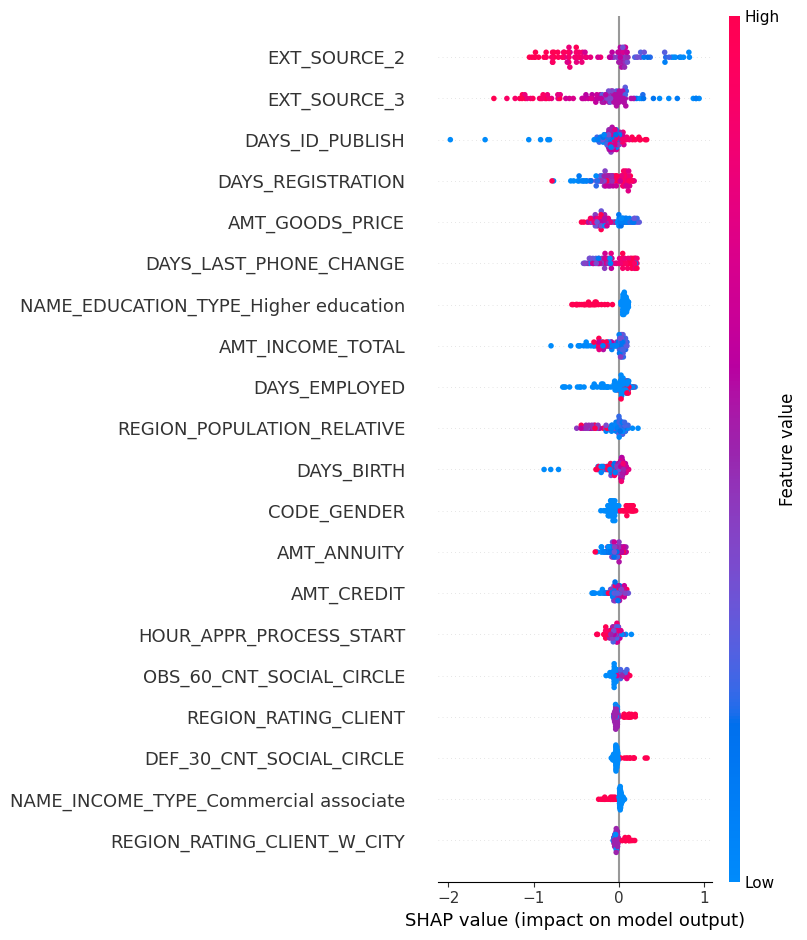

In [10]:
import shap

# Initialize SHAP TreeExplainer for your XGBoost model
explainer = shap.TreeExplainer(model)

# Compute SHAP values (only on a sample to save time)
sample = X_test.sample(100, random_state=42)  # small subset
shap_values = explainer.shap_values(sample)

# Plot summary of global feature importance
shap.summary_plot(shap_values, sample)


In [11]:
# Pick one applicant from test set
i = 0  # or try different values
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], sample.iloc[i])


In [12]:
import joblib

# Save the trained model
joblib.dump(model, 'xgb_model.pkl')
print("Model saved as xgb_model.pkl")

# If in Google Colab, download it locally
try:
    from google.colab import files
    files.download('xgb_model.pkl')
except ImportError:
    print("Not running in Colab, skipping download step.")

Model saved as xgb_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
import pandas as pd

# Step 1: Load dataset
df = pd.read_csv("/content/application_train.csv")  # Update path if needed

# Step 2: Drop unneeded columns
df.drop(columns=["TARGET", "SK_ID_CURR"], inplace=True)

# Step 3: One-hot encode all categorical columns
df_encoded = pd.get_dummies(df)

# Step 4: Save a sample
sample = df_encoded.sample(10, random_state=42)
sample.to_csv("good_sample.csv", index=False)

# Step 5: Download in Colab
from google.colab import files
files.download("good_sample.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>